# Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import subprocess
from ultralytics import YOLO
from pyzbar.pyzbar import decode as pyzbar_decode

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Inference


0: 960x736 5 barcodes, 4 qrs, 38.2ms
Speed: 20.5ms preprocess, 38.2ms inference, 8.2ms postprocess per image at shape (1, 3, 960, 736)
✅ QR ke-1 : (90)DBL9624502804A1(91)240827 (QRCODE)
⚠️ QR ke-2 gagal didecode.
✅ BARCODE ke-3 : 8998898101416 (EAN13)
✅ QR ke-4 : (90)HT122600301(91)221103 (QRCODE)
✅ QR ke-5 : (90)DBL9424502004A1(91)240827 (QRCODE)
✅ BARCODE ke-6 : 8997016510864 (EAN13)
✅ BARCODE ke-7 : 8992695100207 (EAN13)
✅ BARCODE ke-8 : 8992695110206 (EAN13)
✅ BARCODE ke-9 : 8992695110206 (EAN13)
❌ Pyzbar gagal
❌ ZXing juga gagal


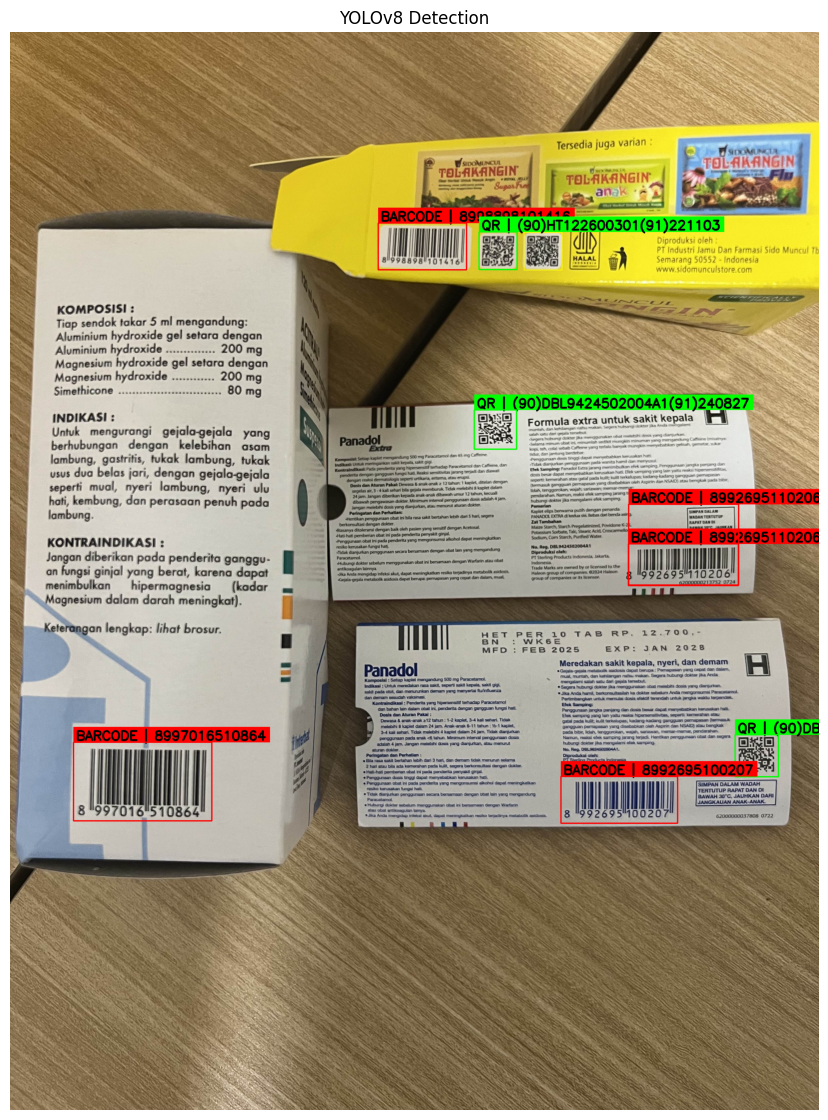


✅ Hasil decode disimpan ke: decoded_barcode_5.csv


In [ ]:
# ===== CONFIG =====
img_path = "/content/barcode_5.jpg"
model_path = "/content/best.pt"
zxing_jar = "/content/zxing/zxing-commandline-0.2.4.jar"
resize_factor = 2.5
padding = 20
save_failed = True

# ===== OUTPUT FILE =====
output_csv = f"decoded_{os.path.basename(img_path).split('.')[0]}.csv"

# ===== LOAD MODEL & IMAGE =====
model = YOLO(model_path)
img = cv2.imread(img_path)
img_draw = img.copy()
decoded_data = []

# ===== DETEKSI YOLOv8 =====
results = model.predict(source=img, conf=0.4, imgsz=960)

for r in results:
    for i, box in enumerate(r.boxes):
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = int(box.cls)
        label = model.names[cls]

        h, w = img.shape[:2]
        x1p, y1p = max(0, x1 - padding), max(0, y1 - padding)
        x2p, y2p = min(w, x2 + padding), min(h, y2 + padding)

        crop = img[y1p:y2p, x1p:x2p]
        crop_resized = cv2.resize(crop, None, fx=resize_factor, fy=resize_factor)

        found = False
        for angle in [0, 90, 180, 270]:
            if found: break
            rotated = {
                0: crop_resized,
                90: cv2.rotate(crop_resized, cv2.ROTATE_90_CLOCKWISE),
                180: cv2.rotate(crop_resized, cv2.ROTATE_180),
                270: cv2.rotate(crop_resized, cv2.ROTATE_90_COUNTERCLOCKWISE)
            }[angle]

            gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)

            # === Multi preprocessing untuk barcode ===
            methods = [
                ("original", rotated),
                ("gray", gray),
                ("sharpen", cv2.convertScaleAbs(gray, alpha=1.7, beta=10)),
                ("adaptive_mean", cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                                        cv2.THRESH_BINARY, 41, 10)),
                ("otsu", cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]),
                ("binary_140", cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)[1]),
                ("clahe", cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)),
            ]

            for method_name, processed in methods:
                decoded = pyzbar_decode(processed)
                if decoded:
                    for d in decoded:
                        content = d.data.decode("utf-8")
                        btype = d.type
                        print(f"✅ {label.upper()} ke-{i+1} : {content} ({btype})")

                        decoded_data.append({
                            "source": label, "content": content, "type": btype,
                            "x1": x1, "y1": y1, "x2": x2, "y2": y2
                        })

                        color = (0, 0, 255) if label == "barcode" else (0, 255, 0)
                        label_text = f"{label.upper()} | {content}"
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        font_scale = 1.6
                        font_thickness = 5
                        (text_w, text_h), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
                        cv2.rectangle(img_draw, (x1, y1 - text_h - 20), (x1 + text_w + 20, y1), color, -1)
                        cv2.putText(img_draw, label_text, (x1 + 10, y1 - 8), font, font_scale, (0, 0, 0), font_thickness)
                        cv2.rectangle(img_draw, (x1, y1), (x2, y2), color, 4)
                        found = True
                        break
                if found:
                    break

        if not found:
            print(f"⚠️ {label.upper()} ke-{i+1} gagal didecode.")
            cv2.rectangle(img_draw, (x1, y1), (x2, y2), (0, 255, 255), 2)
            if save_failed:
                cv2.imwrite(f"failed_crop_{i+1}.jpg", crop_resized)

# ===== FALLBACK PYZBAR =====
fallback_found = False
for angle in [0, 90, 180, 270]:
    full_rotated = {
        0: img.copy(),
        90: cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),
        180: cv2.rotate(img, cv2.ROTATE_180),
        270: cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    }[angle]

    decoded = pyzbar_decode(full_rotated)
    for d in decoded:
        content = d.data.decode("utf-8")
        btype = d.type
        x, y, w, h = d.rect
        if content not in [d["content"] for d in decoded_data]:
            print(f"✅ Fallback : {content} ({btype})")
            decoded_data.append({
                "source": f"fallback_{angle}", "content": content, "type": btype,
                "x1": x, "y1": y, "x2": x+w, "y2": y+h
            })

            color = (255, 0, 255)  
            label_text = f"FALLBACK | {content}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1.6
            font_thickness = 5
            (text_w, text_h), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)
            y_top = max(y - text_h - 20, 0)
            cv2.rectangle(img_draw, (x, y_top), (x + text_w + 20, y), color, -1)
            cv2.putText(img_draw, label_text, (x + 10, y - 8), font, font_scale, (0, 0, 0), font_thickness)
            cv2.rectangle(img_draw, (x, y), (x + w, y + h), color, 4)

            fallback_found = True

# ===== ZXING FALLBACK =====
if not fallback_found:
    print("❌ Pyzbar gagal")

    try:
        cmd = [
            "java", "-cp", zxing_jar,
            "com.google.zxing.client.j2se.CommandLineRunner",
            "--try_harder", "--multi", img_path
        ]
        zxing_result = subprocess.check_output(cmd, stderr=subprocess.DEVNULL).decode("utf-8")
        print("✅ ZXing berhasil membaca:\n")
        print(zxing_result)

        for line in zxing_result.splitlines():
            line = line.strip()
            if line and not line.startswith("file:"):
                decoded_data.append({
                    "source": "zxing", "content": line, "type": "ZXing",
                    "x1": None, "y1": None, "x2": None, "y2": None
                })
    except subprocess.CalledProcessError:
        print("❌ ZXing juga gagal")

# ===== VISUALISASI AKHIR =====
plt.figure(figsize=(12, 14))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8 Detection")
plt.axis("off")
plt.show()

# ===== SIMPAN HASIL DECODE =====
if decoded_data:
    pd.DataFrame(decoded_data).to_csv(output_csv, index=False)
    print(f"\n✅ Hasil decode disimpan ke: {output_csv}")
else:
    print("\n⚠️ Tidak ada barcode yang berhasil didecode.")


- Model YOLOv8n berhasil mendeteksi 5 barcode dan 4 QR code dengan akurasi tinggi pada gambar uji. Dari hasil tersebut, 8 kode berhasil decode menggunakan pyzbar (dengan rotasi dan preprocessing), sedangkan 1 QR code gagal didecode, bahkan setelah fallback menggunakan ZXing. QR code yang gagal ini kemungkinan merupakan kasus ekstrem, misalnya karena kualitas gambar buruk, miring ekstrem, atau pencahayaan yang tidak ideal. Selain itu, terdapat duplikasi deteksi pada satu barcode yang sama. Secara keseluruhan, pipeline ini terbukti efektif dan lumayan andal dalam mengenali serta membaca mayoritas barcode dan QR code. Semua hasil telah disimpan dalam file CSV untuk dokumentasi lebih lanjut.